#Librerias

In [1]:
pip install shap catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from shapely import box
from shapely.geometry import Polygon,box,Point
import IPython
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score,roc_curve,confusion_matrix,log_loss
from imblearn.over_sampling import SMOTE
import fiona
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import shap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.utils.class_weight import compute_class_weight
import scipy as sp
from pyproj import Transformer

In [3]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = '/content/drive/MyDrive/modelo_arauco_1/modelos_finales'
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


In [5]:
merger = pd.read_parquet(path+"/train_3_3_final.parquet")
merger=merger.dropna()

src_crs = 'epsg:32718'
target_crs = 'epsg:4326'


transformer = Transformer.from_crs(src_crs, target_crs)

lat, lon = transformer.transform(merger['x'].values, merger['y'].values)

# Add the new columns to the DataFrame
merger['longitud'] = lon
merger['latitud'] = lat

merger = merger.drop(["x","y"],axis=1)

In [6]:
merger.head(5)

,cuadrilla,dia,incendio,geometry,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,...,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,longitud,latitud
0,0,1,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.533333,0.0,-73.942629,-38.432372
1,0,2,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.900000,0.0,-73.942629,-38.432372
2,0,3,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.175000,0.0,-73.942629,-38.432372
3,0,4,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.000000,0.0,-73.942629,-38.432372
4,0,5,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,17.825000,0.0,-73.942629,-38.432372


#Correlaciones

In [7]:
merger.shape

(1080035, 22)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


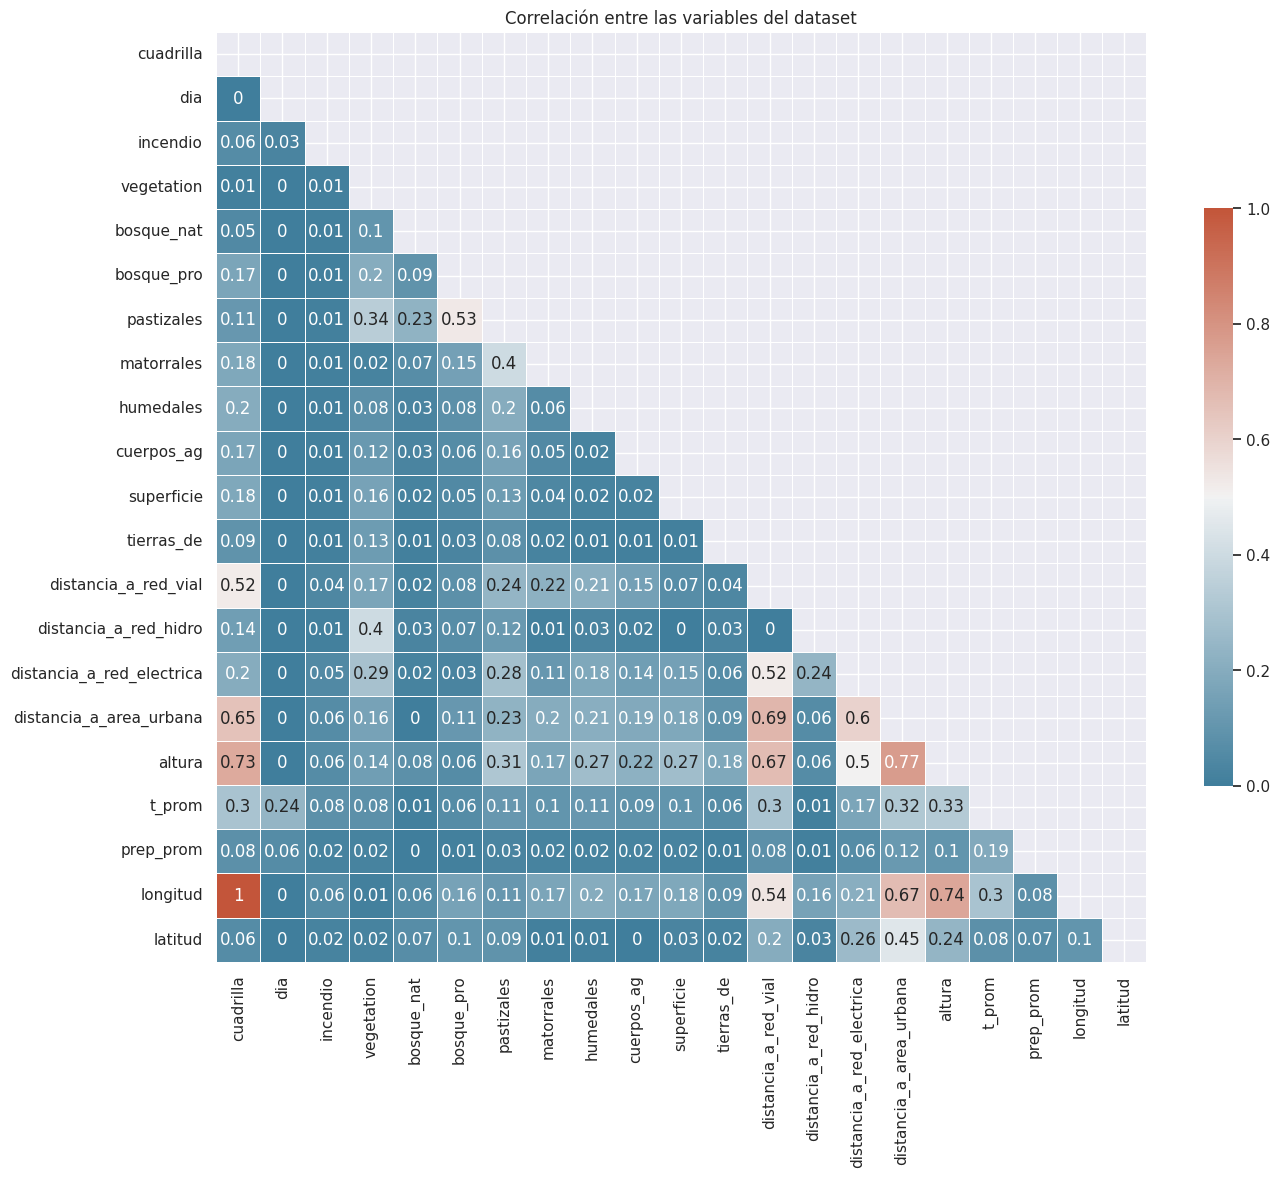

In [8]:
corr = np.abs(merger.corr()).round(2)
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
# Draw the heatmap with the mask and correct aspect ratio
plt.title("Correlación entre las variables del dataset")
plt.show()

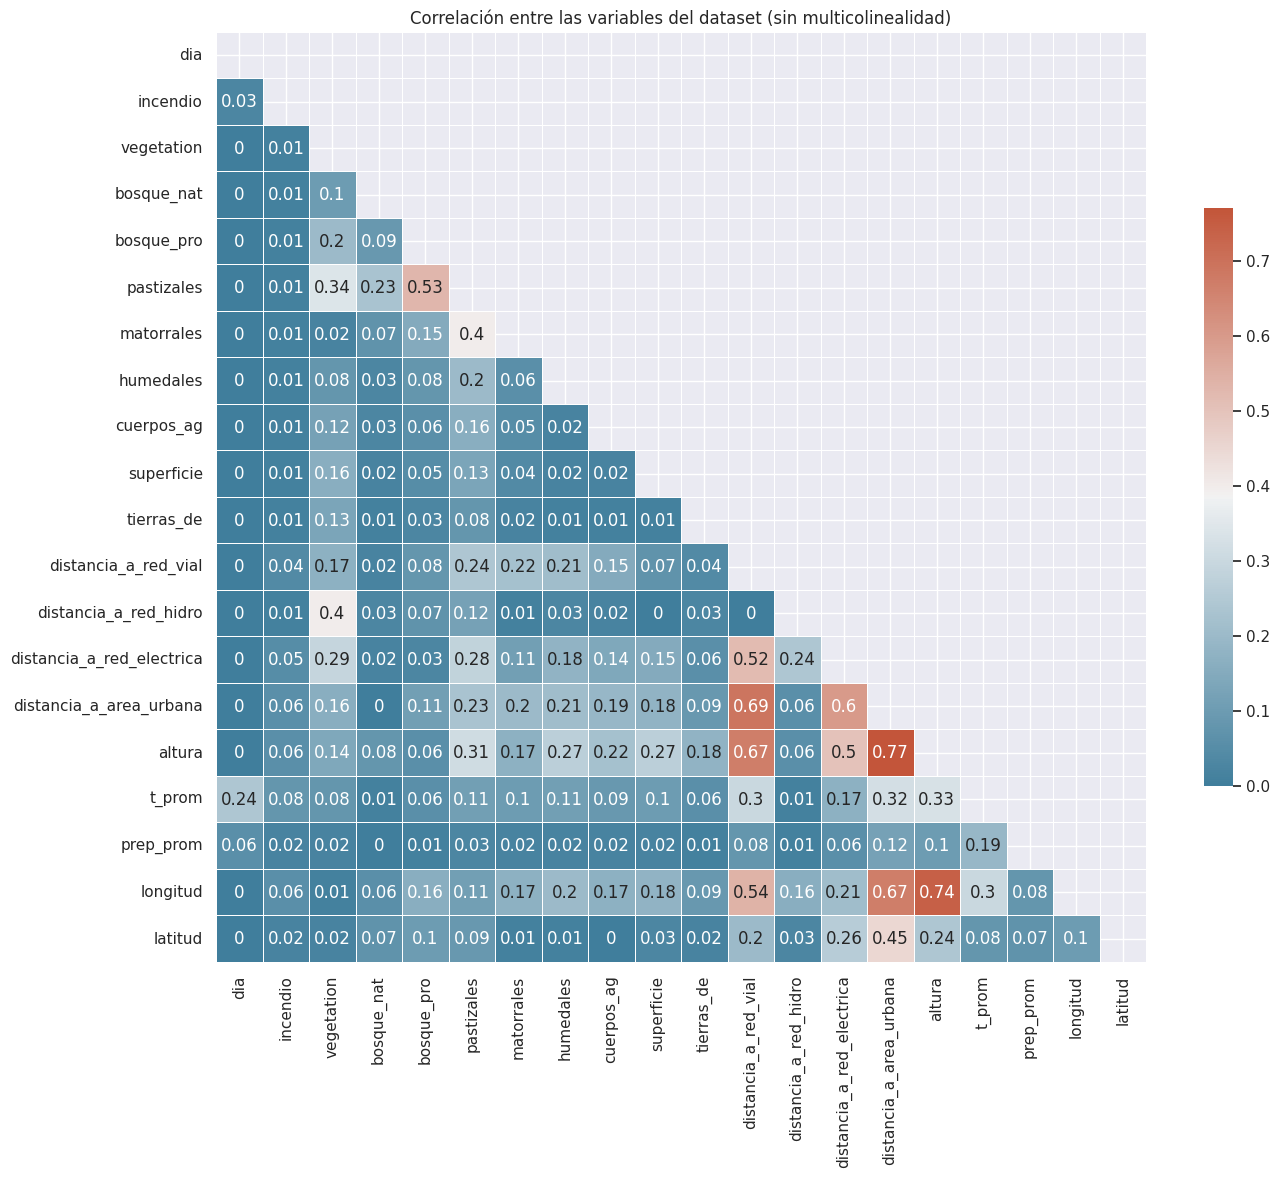

In [9]:
merger_clean = merger.drop(["cuadrilla","geometry"],axis=1)
corr = np.abs(merger_clean.corr()).round(2)
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
# Draw the heatmap with the mask and correct aspect ratio
plt.title("Correlación entre las variables del dataset (sin multicolinealidad)")
plt.show()

#Creación de conjuntos train y test

In [10]:
X = merger_clean.drop(['incendio'], axis=1)
y = merger_clean['incendio']
print(merger_clean["incendio"].value_counts())

0    1072716
1       7319
Name: incendio, dtype: int64


In [11]:
class_weights = dict({0: 1, 1: len(y) / sum(y)})
class_weights

{0: 1, 1: 147.56592430659927}

In [12]:

pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.55))])

no_escalar = X[["dia","vegetation","longitud","latitud"]]

X_esc = pd.DataFrame(MinMaxScaler().fit_transform(X.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_esc[["dia","vegetation","longitud","latitud"]] = no_escalar

X_train, X_test, y_train, y_test = train_test_split(X_esc, y, test_size=0.2, random_state=42)
X_resampled_train, y_resampled_train = pipeline.fit_resample(X_train, y_train)



In [13]:
display(X_resampled_train)

,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,dia,vegetation,longitud,latitud
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.135371,0.009670,0.627846,0.534536,0.498312,0.564207,0.000000,92,446,-71.232601,-37.673918
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.113802,0.002055,0.249122,0.456050,0.407794,0.517119,0.000000,205,288,-71.497863,-37.817239
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034717,0.023897,0.350368,0.156978,0.001534,0.723233,0.000000,79,444,-73.365170,-38.128354
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.511925,0.016693,0.393585,0.247132,0.420988,0.103470,0.000000,246,318,-71.530486,-37.115473
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015478,0.005486,0.141283,0.095192,0.006444,0.651890,0.000000,310,289,-73.450591,-37.318388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330181,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015829,0.007707,0.060679,0.022899,0.062162,0.756484,0.000000,334,244,-73.530978,-37.686788
1330182,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031725,0.018657,0.032493,0.026241,0.047980,0.725643,0.000000,327,241,-73.076750,-37.695333
1330183,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013570,0.014020,0.098561,0.039643,0.056690,0.706207,0.000000,327,246,-73.537443,-37.606491
1330184,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.004924,0.009824,0.130850,0.028677,0.028826,0.816216,0.000000,60,273,-73.351938,-37.957276


In [14]:
print("dim dataset original",merger_clean.shape)
print("dim X resampled train",X_resampled_train.shape)
print("dim y resampled train",y_resampled_train.shape)
print("dim X test",X_test.shape)
print("dim y test",y_test.shape)

dim dataset original (1080035, 20)
dim X resampled train (1330186, 19)
dim y resampled train (1330186,)
dim X test (216007, 19)
dim y test (216007,)


In [15]:
y_resampled_train.value_counts()

0    858185
1    472001
Name: incendio, dtype: int64

In [16]:
y_test.value_counts()

0    214531
1      1476
Name: incendio, dtype: int64

#RFC

In [17]:
model_rfc = RandomForestClassifier(n_estimators=150,max_depth=90,min_samples_leaf=40,min_samples_split=45,criterion="log_loss"\
                                   ,class_weight={0:0.001,1:50})
model_rfc.fit(X_resampled_train, y_resampled_train)
y_pred_rfc = model_rfc.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rfc)

print('Precisión del modelo:', round(accuracy_rf,4))

print('Informe de clasificación:')

print(classification_report(y_test, y_pred_rfc))



Precisión del modelo: 0.7908
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    214531
           1       0.03      0.89      0.05      1476

    accuracy                           0.79    216007
   macro avg       0.51      0.84      0.47    216007
weighted avg       0.99      0.79      0.88    216007



auc: 0.923824314106303


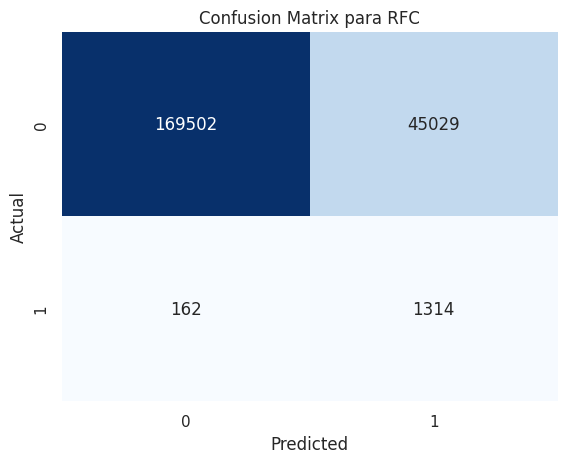

In [18]:
y_pred_proba_rfc = model_rfc.predict_proba(X_test)[:,1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_pred_proba_rfc)
auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)
print("auc:",auc_rfc)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(cm_rfc, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para RFC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

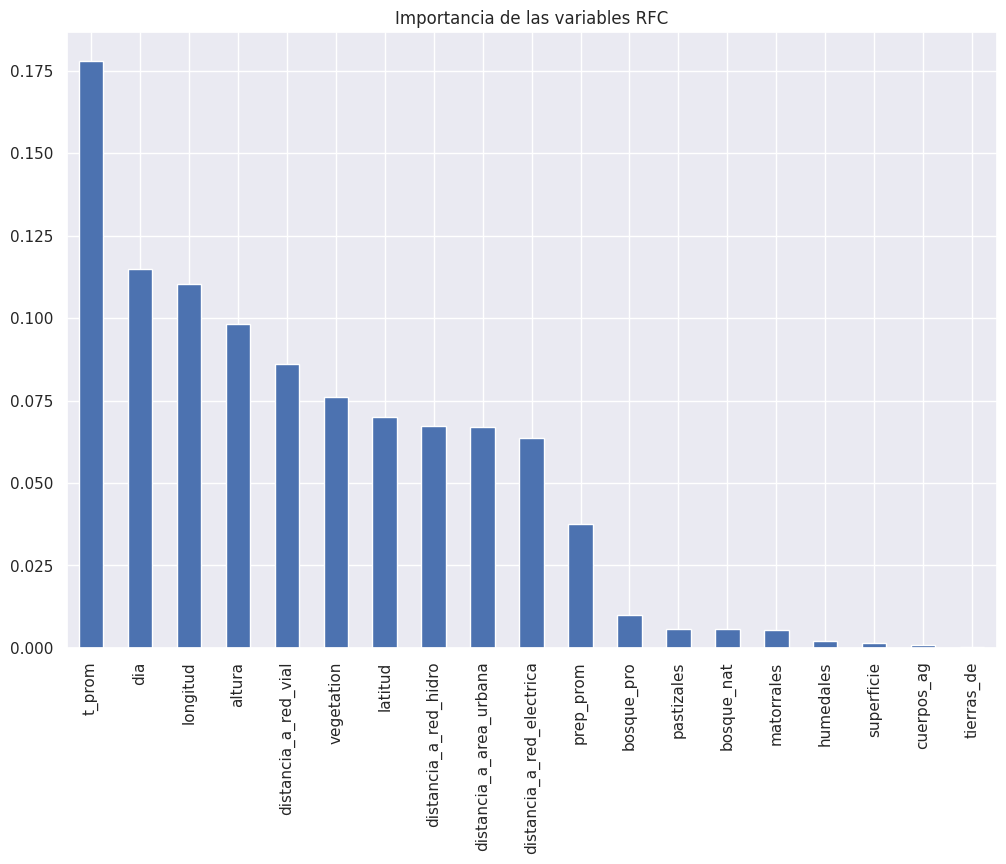

In [19]:
# Get feature importances
feature_importances = pd.Series(model_rfc.feature_importances_, index=X_test.columns)

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables RFC")
plt.show()

#Logit

In [20]:
model_logit = LogisticRegression(solver="lbfgs",max_iter=1500,penalty="l2",warm_start=True)


model_logit.fit(X_resampled_train, y_resampled_train)
y_pred_logit = model_logit.predict(X_test)

accuracy_logit = accuracy_score(y_test, y_pred_logit)

print('Precisión del modelo:', round(accuracy_logit,4))

print('Informe de clasificación:')

print(classification_report(y_test, y_pred_logit))

y_pred_proba_logit = model_logit.predict_proba(X_test)[:,1]
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, y_pred_proba_logit)
auc_logit = roc_auc_score(y_test, y_pred_proba_logit)
print("auc:",auc_logit)



Precisión del modelo: 0.8399
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    214531
           1       0.03      0.73      0.06      1476

    accuracy                           0.84    216007
   macro avg       0.51      0.78      0.49    216007
weighted avg       0.99      0.84      0.91    216007

auc: 0.8761594697674093


In [ ]:
"""from tqdm import tqdm
n_bootstrap = 100
bootstrap_coefs = np.zeros((n_bootstrap, len(model_logit.coef_[0])))
from sklearn.utils import resample
from scipy.stats import norm

for i in tqdm(range(n_bootstrap)):
    X_bootstrap, y_bootstrap = resample(X_resampled_train, y_resampled_train, random_state=i)

    # Fit logistic regression on the bootstrap sample
    logreg_model_bootstrap = LogisticRegression(solver="lbfgs",max_iter=700,warm_start=True,penalty="l2")
    logreg_model_bootstrap.fit(X_bootstrap, y_bootstrap)

    # Store coefficients
    bootstrap_coefs[i, :] = logreg_model_bootstrap.coef_

# Calculate standard errors from bootstrap samples
standard_errors = np.std(bootstrap_coefs, axis=0)

# Calculate z-scores and p-values
z_scores = model_logit.coef_[0] / standard_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))
print(p_values)"""

'from tqdm import tqdm\nn_bootstrap = 100\nbootstrap_coefs = np.zeros((n_bootstrap, len(model_logit.coef_[0])))\nfrom sklearn.utils import resample\nfrom scipy.stats import norm\n\nfor i in tqdm(range(n_bootstrap)):\n    X_bootstrap, y_bootstrap = resample(X_resampled_train, y_resampled_train, random_state=i)\n\n    # Fit logistic regression on the bootstrap sample\n    logreg_model_bootstrap = LogisticRegression(solver="lbfgs",max_iter=700,warm_start=True,penalty="l2")\n    logreg_model_bootstrap.fit(X_bootstrap, y_bootstrap)\n\n    # Store coefficients\n    bootstrap_coefs[i, :] = logreg_model_bootstrap.coef_\n\n# Calculate standard errors from bootstrap samples\nstandard_errors = np.std(bootstrap_coefs, axis=0)\n\n# Calculate z-scores and p-values\nz_scores = model_logit.coef_[0] / standard_errors\np_values = 2 * (1 - norm.cdf(np.abs(z_scores)))\nprint(p_values)'

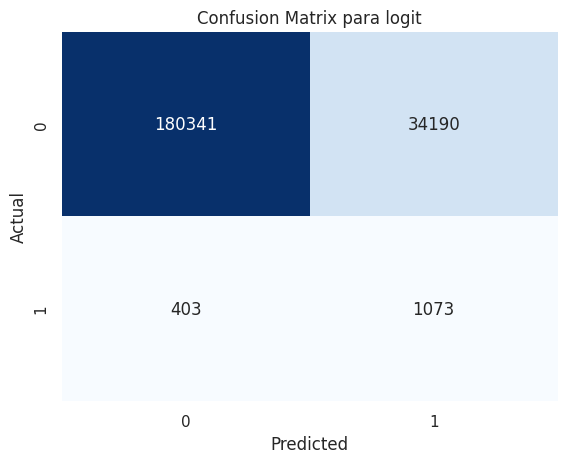

In [21]:
cm_logit = confusion_matrix(y_test, y_pred_logit)
sns.heatmap(cm_logit, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para logit")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
coef_per_variable =model_logit.coef_
df = pd.DataFrame(data=coef_per_variable, columns=X_test.columns)
display(df)

,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,dia,vegetation,longitud,latitud
0,-0.856515,-0.85593,-0.789376,-0.272608,-1.032714,-0.532153,-0.383412,-0.128846,-7.748428,-5.152693,-1.230589,-8.261525,-5.754151,6.801546,-3.755938,-0.000293,-0.000929,-0.186276,0.35064


#Catboost

In [23]:
#iterations=1000, depth=8, learning_rate=1, loss_function='Logloss'
model_cat = CatBoostClassifier(iterations=1500, depth=8, learning_rate=0.03, loss_function='Logloss')
model_cat.fit(X_resampled_train, y_resampled_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=100)
y_pred_cat = model_cat.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_cat)

print('Precisión del modelo:', round(accuracy,4))


print('Informe de clasificación:')

print(classification_report(y_test, y_pred_cat))

y_pred_proba_cat = model_cat.predict_proba(X_test)[:,1]
fpr_cat, tpr_cat, thresholds = roc_curve(y_test, y_pred_proba_cat)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

print("auc:",auc_cat)




0:	learn: 0.6640587	test: 0.6537088	best: 0.6537088 (0)	total: 532ms	remaining: 13m 17s
100:	learn: 0.2997509	test: 0.2355364	best: 0.2355364 (100)	total: 42.4s	remaining: 9m 47s
200:	learn: 0.2585593	test: 0.2045180	best: 0.2045180 (200)	total: 1m 22s	remaining: 8m 52s
300:	learn: 0.2315750	test: 0.1840332	best: 0.1840332 (300)	total: 2m 4s	remaining: 8m 16s
400:	learn: 0.2120265	test: 0.1679478	best: 0.1679478 (400)	total: 2m 44s	remaining: 7m 29s
500:	learn: 0.1948762	test: 0.1546678	best: 0.1546678 (500)	total: 3m 26s	remaining: 6m 50s
600:	learn: 0.1804928	test: 0.1441417	best: 0.1441417 (600)	total: 4m 9s	remaining: 6m 13s
700:	learn: 0.1681059	test: 0.1344217	best: 0.1344217 (700)	total: 4m 50s	remaining: 5m 30s
800:	learn: 0.1572981	test: 0.1262612	best: 0.1262612 (800)	total: 5m 35s	remaining: 4m 53s
900:	learn: 0.1480461	test: 0.1192363	best: 0.1192363 (900)	total: 6m 17s	remaining: 4m 10s
1000:	learn: 0.1400259	test: 0.1131739	best: 0.1131739 (1000)	total: 6m 57s	remaining: 

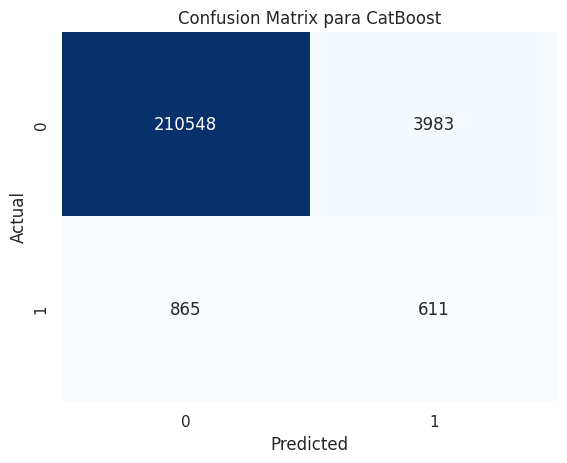

In [24]:
cm_cat = confusion_matrix(y_test, y_pred_cat)
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

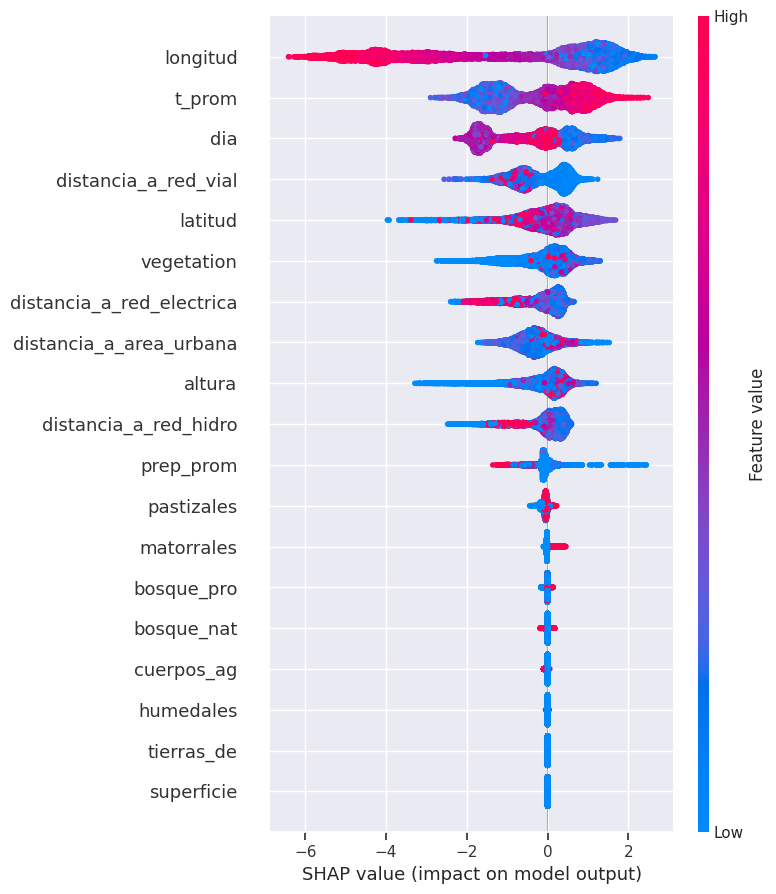

In [25]:
import numpy as np

# Especifica el tamaño del subconjunto aleatorio que deseas
subset_size = 20000
# Obtiene índices aleatorios para seleccionar un subconjunto
random_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
# Selecciona el subconjunto aleatorio de datos
X_test_random_subset = X_test.iloc[random_indices]
# Crea el objeto explainer y calcula los Shapley values
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(X_test_random_subset)
# Resume los efectos de todas las características
shap.summary_plot(shap_values, X_test_random_subset, max_display=30)


#AUC de los 3 modelos

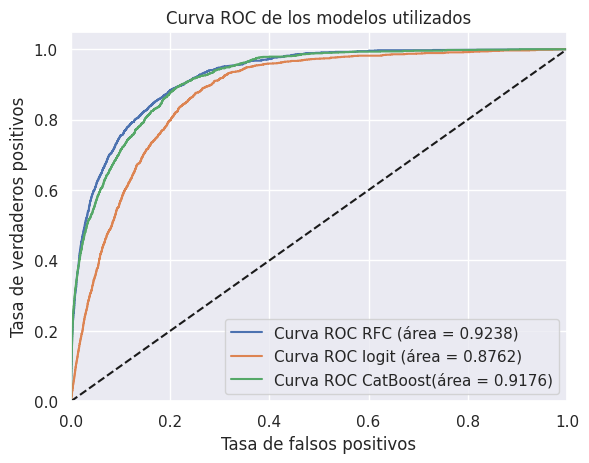

In [26]:
plt.plot(fpr_rfc, tpr_rfc, label='Curva ROC RFC (área = %0.4f)' % auc_rfc)
plt.plot(fpr_logit, tpr_logit, label='Curva ROC logit (área = %0.4f)' % auc_logit)
plt.plot(fpr_cat, tpr_cat, label='Curva ROC CatBoost(área = %0.4f)' % auc_cat)


plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

# Etiquetas de los ejes y título

plt.xlabel('Tasa de falsos positivos')

plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curva ROC de los modelos utilizados')

plt.legend(loc="lower right")

# Mostrar la gráfica

plt.show()


# Holdout

In [27]:
hold_out = pd.read_parquet(path+"/holdout_3_3_final.parquet")
hold_out = hold_out.drop(["cuadrilla","geometry"],axis=1)


src_crs = 'epsg:32718'
target_crs = 'epsg:4326'


transformer = Transformer.from_crs(src_crs, target_crs)

lat, lon = transformer.transform(hold_out['x'].values, hold_out['y'].values)

# Add the new columns to the DataFrame
hold_out['longitud'] = lon
hold_out['latitud'] = lat

hold_out = hold_out.drop(["x","y"],axis=1)

In [28]:
hold_out.head(4)

,dia,incendio,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,longitud,latitud
0,1,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.533333,0.0,-73.942629,-38.432372
1,2,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.900000,0.0,-73.942629,-38.432372
2,3,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.175000,0.0,-73.942629,-38.432372
3,4,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.000000,0.0,-73.942629,-38.432372


In [29]:
X_holdout = hold_out.drop(['incendio'], axis=1)
no_escalar_holdout = X_holdout[["dia","vegetation","longitud","latitud"]]
X_holdout = pd.DataFrame(MinMaxScaler().fit_transform(X_holdout.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_holdout.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_holdout[["dia","vegetation","longitud","latitud"]] = no_escalar_holdout
y_holdout = hold_out['incendio']
X_holdout = X_holdout.reindex(X_test.columns, axis=1)

In [30]:
display(X_resampled_train)

,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,dia,vegetation,longitud,latitud
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.135371,0.009670,0.627846,0.534536,0.498312,0.564207,0.000000,92,446,-71.232601,-37.673918
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.113802,0.002055,0.249122,0.456050,0.407794,0.517119,0.000000,205,288,-71.497863,-37.817239
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034717,0.023897,0.350368,0.156978,0.001534,0.723233,0.000000,79,444,-73.365170,-38.128354
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.511925,0.016693,0.393585,0.247132,0.420988,0.103470,0.000000,246,318,-71.530486,-37.115473
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015478,0.005486,0.141283,0.095192,0.006444,0.651890,0.000000,310,289,-73.450591,-37.318388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330181,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015829,0.007707,0.060679,0.022899,0.062162,0.756484,0.000000,334,244,-73.530978,-37.686788
1330182,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031725,0.018657,0.032493,0.026241,0.047980,0.725643,0.000000,327,241,-73.076750,-37.695333
1330183,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013570,0.014020,0.098561,0.039643,0.056690,0.706207,0.000000,327,246,-73.537443,-37.606491
1330184,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.004924,0.009824,0.130850,0.028677,0.028826,0.816216,0.000000,60,273,-73.351938,-37.957276


In [31]:
y_pred_rfc_holdout = model_rfc.predict(X_holdout)
y_pred_logit_holdout = model_logit.predict(X_holdout)
y_pred_cat_holdout = model_cat.predict(X_holdout)

Precisión del modelo rfc holdout: 0.7885
Precisión del modelo logit holdout: 0.8372
Precisión del modelo cat holdout: 0.9788
Informe de clasificación rfc holdout:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88   1078487
           1       0.01      0.92      0.01      1548

    accuracy                           0.79   1080035
   macro avg       0.50      0.85      0.45   1080035
weighted avg       1.00      0.79      0.88   1080035

Informe de clasificación logit holdout:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91   1078487
           1       0.01      0.85      0.01      1548

    accuracy                           0.84   1080035
   macro avg       0.50      0.85      0.46   1080035
weighted avg       1.00      0.84      0.91   1080035

Informe de clasificación cat holdout:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1078

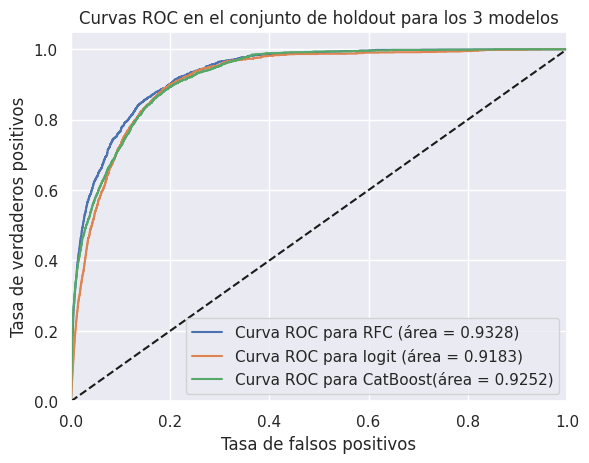

In [32]:

accuracy_rfc_holdout = accuracy_score(y_holdout, y_pred_rfc_holdout)
accuracy_logit_holdout = accuracy_score(y_holdout, y_pred_logit_holdout)
accuracy_cat_holdout = accuracy_score(y_holdout, y_pred_cat_holdout)
print('Precisión del modelo rfc holdout:', round(accuracy_rfc_holdout,4))
print('Precisión del modelo logit holdout:', round(accuracy_logit_holdout,4))
print('Precisión del modelo cat holdout:', round(accuracy_cat_holdout,4))


print('Informe de clasificación rfc holdout:')
print(classification_report(y_holdout, y_pred_rfc_holdout))
print('Informe de clasificación logit holdout:')
print(classification_report(y_holdout, y_pred_logit_holdout))
print('Informe de clasificación cat holdout:')
print(classification_report(y_holdout, y_pred_cat_holdout))


y_pred_proba_rfc_holdout = model_rfc.predict_proba(X_holdout)[:,1]
y_pred_proba_logit_holdout = model_logit.predict_proba(X_holdout)[:,1]
y_pred_proba_cat_holdout = model_cat.predict_proba(X_holdout)[:,1]



fpr_rfc_holdout, tpr_rfc_holdout, thresholds_rfc_holdout = roc_curve(y_holdout, y_pred_proba_rfc_holdout)
auc_rfc_holdout = roc_auc_score(y_holdout, y_pred_proba_rfc_holdout)

fpr_logit_holdout, tpr_logit_holdout, thresholds_logit_holdout = roc_curve(y_holdout, y_pred_proba_logit_holdout)
auc_logit_holdout = roc_auc_score(y_holdout, y_pred_proba_logit_holdout)

fpr_cat_holdout, tpr_cat_holdout, thresholds_cat_holdout = roc_curve(y_holdout, y_pred_proba_cat_holdout)
auc_cat_holdout = roc_auc_score(y_holdout, y_pred_proba_cat_holdout)

plt.plot(fpr_rfc_holdout, tpr_rfc_holdout, label='Curva ROC para RFC (área = %0.4f)' % auc_rfc_holdout)
plt.plot(fpr_logit_holdout, tpr_logit_holdout, label='Curva ROC para logit (área = %0.4f)' % auc_logit_holdout)
plt.plot(fpr_cat_holdout, tpr_cat_holdout, label='Curva ROC para CatBoost(área = %0.4f)' % auc_cat_holdout)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('Tasa de falsos positivos')

plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curvas ROC en el conjunto de holdout para los 3 modelos')

plt.legend(loc="lower right")

# Mostrar la gráfica

plt.show()


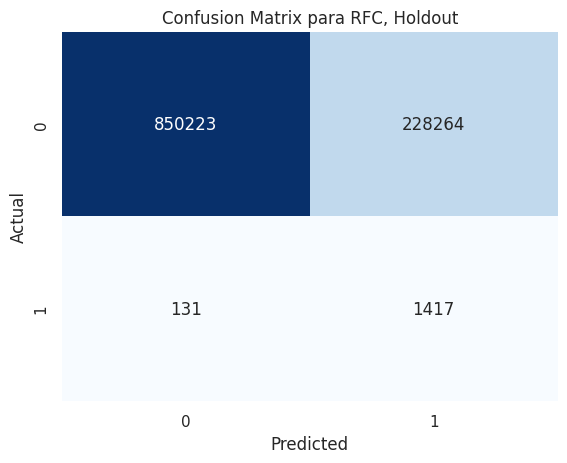

In [33]:
cm_rfc_holdout = confusion_matrix(y_holdout, y_pred_rfc_holdout)
sns.heatmap(cm_rfc_holdout, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para RFC, Holdout")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

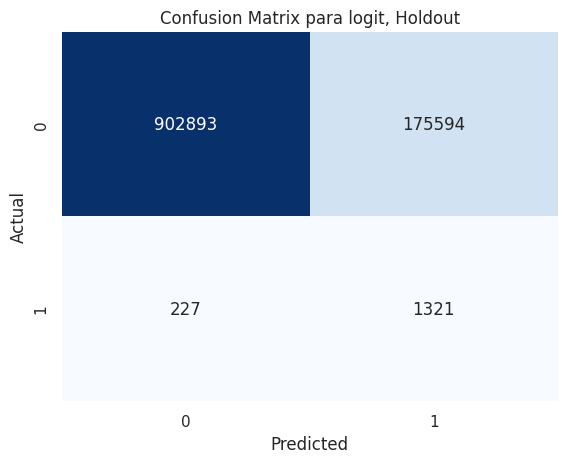

In [34]:
cm_logit_holdout = confusion_matrix(y_holdout, y_pred_logit_holdout)
sns.heatmap(cm_logit_holdout, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para logit, Holdout")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

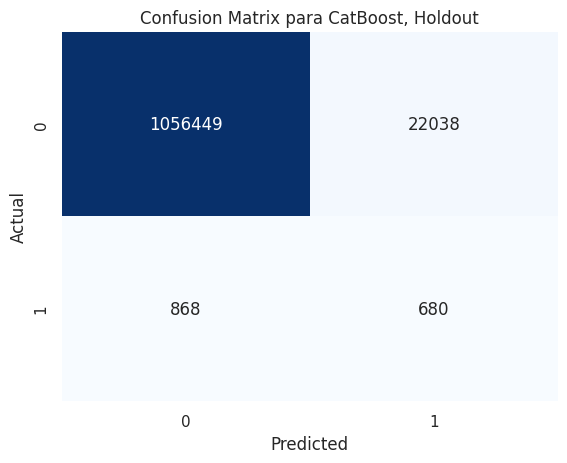

In [35]:
cm_cat_holdout = confusion_matrix(y_holdout, y_pred_cat_holdout)
sns.heatmap(cm_cat_holdout, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para CatBoost, Holdout")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Enero

## Entrenamiento full dataset

In [36]:
train_enero = pd.read_parquet(path+"/df_completo_3_3_final.parquet")
train_enero = train_enero.drop(["cuadrilla","geometry"],axis=1)
src_crs = 'epsg:32718'
target_crs = 'epsg:4326'


transformer = Transformer.from_crs(src_crs, target_crs)

lat, lon = transformer.transform(train_enero['x'].values, train_enero['y'].values)

# Add the new columns to the DataFrame
train_enero['longitud'] = lon
train_enero['latitud'] = lat

train_enero = train_enero.drop(["x","y"],axis=1)

X_enero = train_enero.drop(['incendio'], axis=1)
y_enero = train_enero['incendio']
print(X_enero.shape)

(1080035, 19)


In [37]:
train_enero.head()

,dia,incendio,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,longitud,latitud
0,1,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.533333,0.0,-73.942629,-38.432372
1,2,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.900000,0.0,-73.942629,-38.432372
2,3,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.175000,0.0,-73.942629,-38.432372
3,4,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.000000,0.0,-73.942629,-38.432372
4,5,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,17.825000,0.0,-73.942629,-38.432372


In [38]:
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.55))])

no_escalar_enero = X_enero[["dia","vegetation","longitud","latitud"]]

X_esc_enero = pd.DataFrame(MinMaxScaler().fit_transform(X_enero.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_enero.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_esc_enero[["dia","vegetation","longitud","latitud"]] = no_escalar

X_train_enero, X_test_enero, y_train_enero, y_test_enero = train_test_split(X_esc_enero, y_enero, test_size=0.2, random_state=42)
X_resampled_train_enero, y_resampled_train_enero = pipeline.fit_resample(X_train_enero, y_train_enero)
print("dim dataset original para enero",X_enero.shape)
print("dim X resampled train para enero",X_resampled_train_enero.shape)
print("dim y resampled train para enero",y_resampled_train_enero.shape)
print("dim X test para enero",X_test_enero.shape)
print("dim y test para enero",y_test_enero.shape)


dim dataset original para enero (1080035, 19)
dim X resampled train para enero (1328546, 19)
dim y resampled train para enero (1328546,)
dim X test para enero (216007, 19)
dim y test para enero (216007,)


## RFC Full

In [39]:
model_rfc_enero = RandomForestClassifier(n_estimators=150,max_depth=90,min_samples_leaf=40,min_samples_split=45,criterion="log_loss"\
                                   ,class_weight={0:0.001,1:50})
model_rfc_enero.fit(X_resampled_train_enero, y_resampled_train_enero)
y_pred_rfc_enero = model_rfc_enero.predict(X_test_enero)

accuracy_rf_enero = accuracy_score(y_test_enero, y_pred_rfc_enero)

print('Precisión del modelo:', round(accuracy_rf_enero,4))

print('Informe de clasificación:')

print(classification_report(y_test_enero, y_pred_rfc_enero))


Precisión del modelo: 0.7776
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87    214265
           1       0.03      0.91      0.06      1742

    accuracy                           0.78    216007
   macro avg       0.52      0.84      0.47    216007
weighted avg       0.99      0.78      0.87    216007



auc: 0.9257029484530233


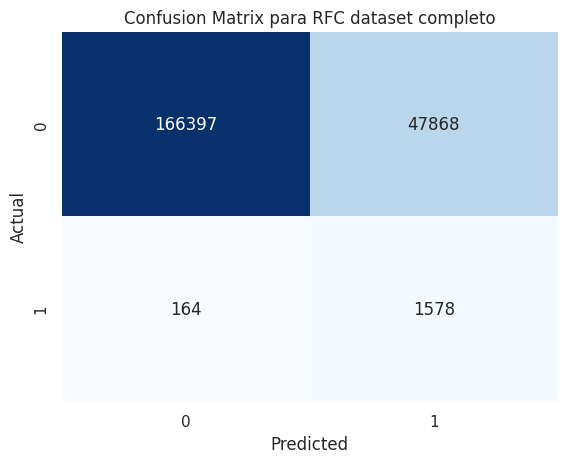

In [40]:
y_pred_proba_rfc_enero = model_rfc_enero.predict_proba(X_test_enero)[:,1]
fpr_rfc_enero, tpr_rfc_enero, thresholds_rfc_enero = roc_curve(y_test_enero, y_pred_proba_rfc_enero)
auc_rfc_enero = roc_auc_score(y_test_enero, y_pred_proba_rfc_enero)
print("auc:",auc_rfc_enero)
cm_rfc_enero = confusion_matrix(y_test_enero, y_pred_rfc_enero)
sns.heatmap(cm_rfc_enero, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para RFC dataset completo")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Logit Full

In [41]:
model_logit_enero = LogisticRegression(solver="lbfgs",max_iter=1500,penalty="l2",warm_start=True)


model_logit_enero.fit(X_resampled_train_enero, y_resampled_train_enero)
y_pred_logit_enero = model_logit_enero.predict(X_test_enero)

accuracy_logit_enero = accuracy_score(y_test_enero, y_pred_logit_enero)

print('Precisión del modelo:', round(accuracy_logit_enero,4))

print('Informe de clasificación:')

print(classification_report(y_test_enero, y_pred_logit_enero))

y_pred_proba_logit_enero = model_logit_enero.predict_proba(X_test_enero)[:,1]
fpr_logit_enero, tpr_logit_enero, thresholds_logit_enero = roc_curve(y_test, y_pred_proba_logit_enero)
auc_logit_enero = roc_auc_score(y_test_enero, y_pred_proba_logit_enero)
print("auc:",auc_logit_enero)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Precisión del modelo: 0.8453
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    214265
           1       0.04      0.73      0.07      1742

    accuracy                           0.85    216007
   macro avg       0.52      0.79      0.49    216007
weighted avg       0.99      0.85      0.91    216007

auc: 0.8799801918088974


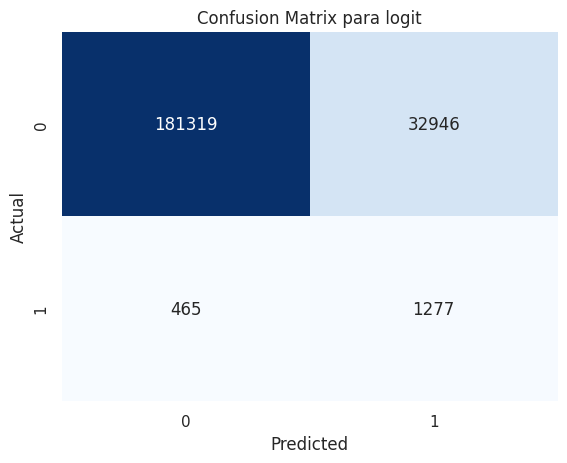

In [42]:
cm_logit_enero = confusion_matrix(y_test_enero, y_pred_logit_enero)
sns.heatmap(cm_logit_enero, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para logit")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Catboost Full

In [43]:
model_cat_enero = CatBoostClassifier(iterations=1500, depth=8, learning_rate=0.03, loss_function='Logloss')
model_cat_enero.fit(X_resampled_train_enero, y_resampled_train_enero, eval_set=(X_test_enero, y_test_enero), early_stopping_rounds=100, verbose=100)
y_pred_cat_enero = model_cat_enero.predict(X_test_enero)

accuracy_cat_enero = accuracy_score(y_test_enero, y_pred_cat_enero)

print('Precisión del modelo:', round(accuracy_cat_enero,4))


print('Informe de clasificación:')

print(classification_report(y_test_enero, y_pred_cat_enero))

y_pred_proba_cat_enero = model_cat.predict_proba(X_test_enero)[:,1]
fpr_cat_enero, tpr_cat_enero, thresholds_cat_enero = roc_curve(y_test_enero, y_pred_proba_cat_enero)
auc_cat_enero = roc_auc_score(y_test_enero, y_pred_proba_cat_enero)

print("auc:",auc_cat)


0:	learn: 0.6622970	test: 0.6526309	best: 0.6526309 (0)	total: 478ms	remaining: 11m 56s
100:	learn: 0.2961452	test: 0.2338887	best: 0.2338887 (100)	total: 44.5s	remaining: 10m 15s
200:	learn: 0.2559821	test: 0.2033328	best: 0.2033328 (200)	total: 1m 23s	remaining: 9m 2s
300:	learn: 0.2318433	test: 0.1841627	best: 0.1841627 (300)	total: 2m 5s	remaining: 8m 21s
400:	learn: 0.2127632	test: 0.1691489	best: 0.1691489 (400)	total: 2m 56s	remaining: 8m 3s
500:	learn: 0.1968039	test: 0.1569118	best: 0.1569118 (500)	total: 3m 42s	remaining: 7m 24s
600:	learn: 0.1816880	test: 0.1456888	best: 0.1456888 (600)	total: 4m 24s	remaining: 6m 36s
700:	learn: 0.1707020	test: 0.1373547	best: 0.1373547 (700)	total: 5m 6s	remaining: 5m 49s
800:	learn: 0.1592710	test: 0.1283890	best: 0.1283890 (800)	total: 5m 49s	remaining: 5m 5s
900:	learn: 0.1509441	test: 0.1219801	best: 0.1219801 (900)	total: 6m 33s	remaining: 4m 21s
1000:	learn: 0.1431446	test: 0.1161584	best: 0.1161584 (1000)	total: 7m 13s	remaining: 3m

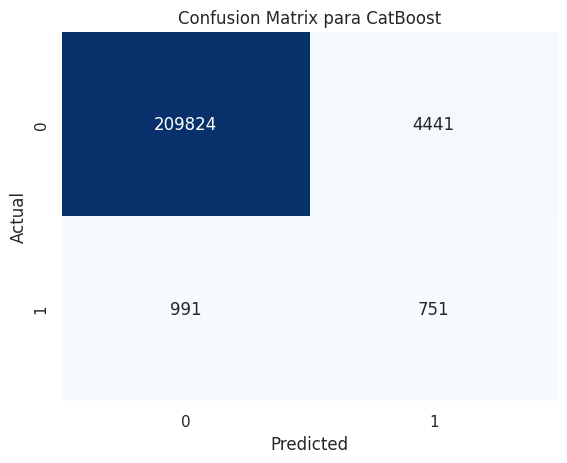

In [44]:
cm_cat_enero = confusion_matrix(y_test_enero, y_pred_cat_enero)
sns.heatmap(cm_cat_enero, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

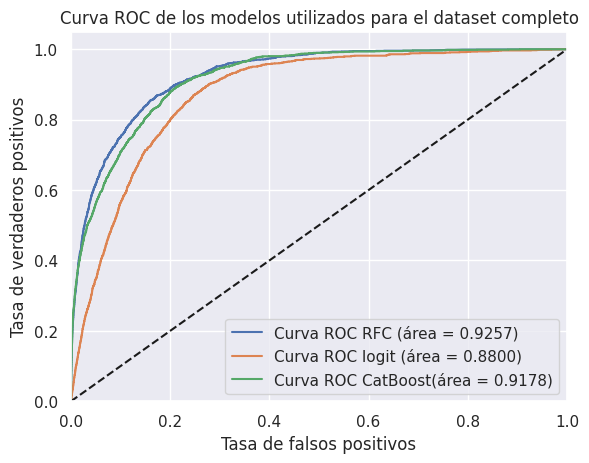

In [45]:
plt.plot(fpr_rfc_enero, tpr_rfc_enero, label='Curva ROC RFC (área = %0.4f)' % auc_rfc_enero)
plt.plot(fpr_logit_enero, tpr_logit_enero, label='Curva ROC logit (área = %0.4f)' % auc_logit_enero)
plt.plot(fpr_cat_enero, tpr_cat_enero, label='Curva ROC CatBoost(área = %0.4f)' % auc_cat_enero)


plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

# Etiquetas de los ejes y título

plt.xlabel('Tasa de falsos positivos')

plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curva ROC de los modelos utilizados para el dataset completo')

plt.legend(loc="lower right")

# Mostrar la gráfica

plt.show()

##Procesamiento de coordenadas datos enero

In [46]:
enero_prom = pd.read_parquet(path+"/df_enero_3_3_escenario_prom-1.parquet")
enero_desf = pd.read_parquet(path+"/df_enero_3_3_escenario_desfav.parquet")
enero_fav = pd.read_parquet(path+"/df_enero_3_3_escenario_fav.parquet")


In [47]:
src_crs = 'epsg:32718'
target_crs = 'epsg:4326'

# Create a Transformer for the coordinate conversion
transformer = Transformer.from_crs(src_crs, target_crs)

# Apply the coordinate conversion to the entire DataFrame
lat1, lon1 = transformer.transform(enero_prom['x'].values, enero_prom['y'].values)
lat2, lon2 = transformer.transform(enero_fav['x'].values, enero_fav['y'].values)
lat3, lon3 = transformer.transform(enero_desf['x'].values, enero_desf['y'].values)
# Add the new columns to the DataFrame

enero_desf["longitud"],enero_desf["latitud"] = lon3,lat3
enero_fav["longitud"],enero_fav["latitud"] = lon2,lat2
enero_prom["longitud"],enero_prom["latitud"] = lon1,lat1
# Print the resulting DataFrame with converted coordinates
enero_desf  = enero_desf.drop(["x","y"],axis=1)
enero_fav  = enero_fav.drop(["x","y"],axis=1)
enero_prom  = enero_prom.drop(["x","y"],axis=1)


In [48]:
enero_prom.head()

,cuadrilla,dia,geometry,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,...,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,longitud,latitud
0,0,1,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.420000,0.150000,-73.942629,-38.432372
1,0,2,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.120000,0.900000,-73.942629,-38.432372
2,0,3,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.916667,1.216667,-73.942629,-38.432372
3,0,4,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.850000,2.050000,-73.942629,-38.432372
4,0,5,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.350000,2.616667,-73.942629,-38.432372


## Enero Promedio

In [49]:
X_enero_prom = enero_prom.drop(["cuadrilla","geometry"], axis=1)
no_escalar_enero_prom = X_enero_prom[["dia","vegetation","longitud","latitud"]]
X_enero_prom = pd.DataFrame(MinMaxScaler().fit_transform(X_enero_prom.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_holdout.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_enero_prom[["dia","vegetation","longitud","latitud"]] = no_escalar_enero_prom
X_enero_prom = X_enero_prom.reindex(columns=X_test.columns)


In [50]:
y_pred_rfc_enero_prom = model_rfc_enero.predict(X_enero_prom)
y_pred_logit_enero_prom = model_logit_enero.predict(X_enero_prom)
y_pred_cat_enero_prom = model_cat_enero.predict(X_enero_prom)


## Enero desfavorable

In [51]:
X_enero_desfav = enero_desf.drop(["cuadrilla","geometry"], axis=1)
no_escalar_enero_desfav = X_enero_desfav[["dia","vegetation","longitud","latitud"]]
X_enero_desfav = pd.DataFrame(MinMaxScaler().fit_transform(X_enero_desfav.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_enero_desfav.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_enero_desfav[["dia","vegetation","longitud","latitud"]] = no_escalar_enero_desfav
X_enero_desfav = X_enero_desfav.reindex(columns=X_test.columns)

In [52]:
y_pred_rfc_enero_desfav = model_rfc_enero.predict(X_enero_desfav)
y_pred_logit_enero_desfav = model_logit_enero.predict(X_enero_desfav)
y_pred_cat_enero_desfav = model_cat_enero.predict(X_enero_desfav)




## Enero Favorable

In [53]:
X_enero_fav = enero_fav.drop(["cuadrilla","geometry"], axis=1)
no_escalar_enero_fav = X_enero_fav[["dia","vegetation","longitud","latitud"]]
X_enero_fav = pd.DataFrame(MinMaxScaler().fit_transform(X_enero_fav.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_enero_fav.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_enero_fav[["dia","vegetation","longitud","latitud"]] = no_escalar_enero_fav
X_enero_fav = X_enero_fav.reindex(columns=X_test.columns)

In [54]:
y_pred_rfc_enero_fav = model_rfc_enero.predict(X_enero_fav)
y_pred_logit_enero_fav = model_logit_enero.predict(X_enero_fav)
y_pred_cat_enero_fav = model_cat_enero.predict(X_enero_fav)


# Importancias

In [ ]:
"""explainer_catboost = shap.TreeExplainer(model_cat)
shap_values_catboost = explainer_catboost.shap_values(X_test[:100])"""

In [ ]:
"""explainer_logreg = shap.LinearExplainer(model_logit,X_test[:100])
shap_values_logreg = explainer_logreg.shap_values(X_test[:100])"""

In [ ]:
"""
# Get feature importances
feature_importances = pd.Series(model_rfc.feature_importances_, index=X_test.columns)

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables RFC")
plt.show()
"""


In [ ]:
# CatBoostClassifier
#shap.summary_plot(shap_values_catboost, X_test[:100])


In [ ]:

# Logit
#shap.summary_plot(shap_values_logreg, X_test[:100])

In [ ]:
"""
shap_values_rf_holdout = explainer_rfc.shap_values(X_test_holdout[:100])

shap_values_logreg_holdout = explainer_logreg.shap_values(X_test_holdout[:100])


shap_values_catboost_holdout = explainer_catboost.shap_values(X_test_holdout[:100])
"""

In [ ]:
#shap.summary_plot(shap_values_logreg_holdout, X_test_holdout[:100])

In [ ]:
#shap.summary_plot(shap_values_catboost_holdout, X_test_holdout[:100])

In [ ]:
"""# Get feature importances
feature_importances = pd.Series(model_rfc.feature_importances_, index=X_test_holdout.columns)

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables Random Forest en conjunto holdout")
plt.show()"""

#Visualizaciones

Para las visualizar la probabilidad de ignición por zona promedio se mezclarán los resultados de los modelos Random Forest Classifier y CatBoost, puesto que RFC es el mejor predictor de la clase positiva y CBC el mejor predictor de la clase negativa. Lo que puede ofrecer una evaluación más completa y confiable, aprovechando las fortalezas complementarias de ambos modelos y reduciendo sesgos individuales. Esto permite obtener una imagen más precisa y equilibrada de las áreas con mayor riesgo de incendios forestales.

In [55]:
pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 34.8 MB/s eta 0:00:00


In [56]:
import contextily as ctx

In [57]:
chile = gp.read_file(path+'/Regiones/Regional.shp')

biobio = chile[chile['Region'] == 'Región del Bío-Bío']

biobio = biobio.to_crs(epsg=4326)

##Test

Random Forest

In [58]:
y_pred_df_rfc = pd.DataFrame(y_pred_proba_rfc_enero, columns=['prob_incendio'], index=X_test_enero.index)
merged_pred_rfc = pd.concat([X_test_enero, y_pred_df_rfc], axis=1)

prob_incendio_cuadrilla_rfc = merged_pred_rfc.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_rfc.rename(columns={'prob_incendio': 'prom_prob_incendio_rfc'}, inplace=True)

CatBoost

In [59]:
y_pred_df_cat = pd.DataFrame(y_pred_proba_cat_enero, columns=['prob_incendio'], index=X_test_enero.index)
merged_pred_cat = pd.concat([X_test_enero, y_pred_df_cat], axis=1)

prob_incendio_cuadrilla_cat = merged_pred_cat.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_cat.rename(columns={'prob_incendio': 'prom_prob_incendio_cat'}, inplace=True)

Mezcla

In [73]:
umbral = 1
merged_probs = prob_incendio_cuadrilla_cat.merge(prob_incendio_cuadrilla_rfc, on=['latitud', 'longitud'], how='inner')
# Crear la nueva columna 'prom_prob_incendio' basada en las condiciones
merged_probs['prom_prob_incendio'] = np.where(merged_probs['prom_prob_incendio_cat'] < umbral,
                                              merged_probs['prom_prob_incendio_cat'],
                                              merged_probs['prom_prob_incendio_rfc'])

Gráfico suavizado

In [ ]:
# @title
from scipy.ndimage import gaussian_filter
# Aplicar un filtro gaussiano a los datos de probabilidad de incendio
prob_incendio_suavizado = gaussian_filter(merged_probs['prom_prob_incendio'], sigma=5)

# Agregar la columna con los datos suavizados al DataFrame
merged_probs['prob_incendio_suavizado'] = prob_incendio_suavizado

Text(59.5, 0.5, 'Latitud (grados)')

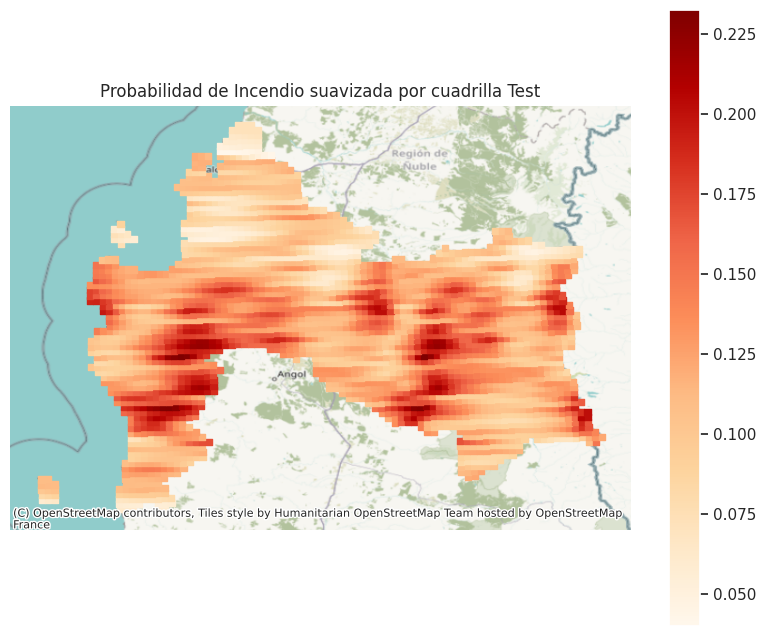

In [ ]:
# @title
# Crear GeoDataFrame con las coordenadas de latitud y longitud
heatmap_gdf = gp.GeoDataFrame(merged_probs, geometry=gp.points_from_xy(merged_probs.longitud, merged_probs.latitud))

# Crear el gráfico base con la región del Biobío y las cuadrillas
fig, ax = plt.subplots(figsize=(10, 8))
biobio.plot(ax=ax, facecolor="#87CEEB", edgecolor='grey')

# Crear el heatmap de la probabilidad de incendio suavizada
heatmap_gdf.plot(column='prob_incendio_suavizado', cmap='OrRd', ax=ax, legend=True, markersize=20, marker='s')

# Agregar el fondo del mapa
ctx.add_basemap(ax, crs=biobio.crs)  # Ajusta "biobio.crs" a la proyección de tu datos

# Remover las líneas de los ejes X e Y
ax.axis('off')

# Ajustar título y leyenda
plt.title('Probabilidad de Incendio suavizada por cuadrilla Test')
plt.xlabel("Longitud (grados)")
plt.ylabel("Latitud (grados)")

Gráfico sin suavizar

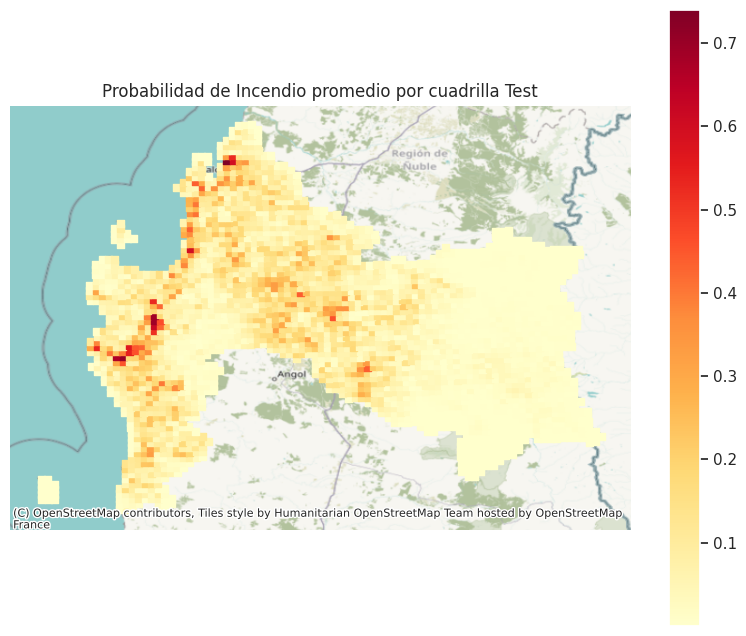

In [74]:
# Crear GeoDataFrame con las coordenadas de latitud y longitud
heatmap_gdf = gp.GeoDataFrame(merged_probs, geometry=gp.points_from_xy(merged_probs.longitud, merged_probs.latitud))

# Crear el gráfico base con la región del Biobío y las cuadrillas
fig, ax = plt.subplots(figsize=(10, 8))
biobio.plot(ax=ax, facecolor="#87CEEB", edgecolor='grey')

# Crear el heatmap de la probabilidad de incendio basado en la latitud y longitud
heatmap_gdf.plot(column='prom_prob_incendio', cmap='YlOrRd', ax=ax, legend=True, markersize=25, marker='s')

# Agregar el fondo del mapa
ctx.add_basemap(ax, crs=biobio.crs)  # Ajusta "biobio.crs" a la proyección de tu datos

# Remover las líneas de los ejes X e Y
ax.axis('off')

# Ajustar título y leyenda
plt.title('Probabilidad de Incendio promedio por cuadrilla Test')
plt.xlabel("Longitud (grados)")
plt.ylabel("Latitud (grados)")

plt.show()

##Holdout

Random Forest

In [75]:
y_pred_df_rfc_holdout = pd.DataFrame(y_pred_proba_rfc_holdout, columns=['prob_incendio'], index=X_holdout.index)
merged_pred_rfc_holdout = pd.concat([hold_out, y_pred_df_rfc_holdout], axis=1)

prob_incendio_cuadrilla_rfc_holdout = merged_pred_rfc_holdout.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_rfc_holdout.rename(columns={'prob_incendio': 'prom_prob_incendio_rfc'}, inplace=True)

CatBoost

In [76]:
y_pred_df_cat_holdout = pd.DataFrame(y_pred_proba_cat_holdout, columns=['prob_incendio'], index=X_holdout.index)
merged_pred_cat_holdout = pd.concat([hold_out, y_pred_df_cat_holdout], axis=1)

prob_incendio_cuadrilla_cat_holdout = merged_pred_cat_holdout.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_cat_holdout.rename(columns={'prob_incendio': 'prom_prob_incendio_cat'}, inplace=True)

Mezcla

In [131]:
umbral = 0.5
merged_probs_holdout = prob_incendio_cuadrilla_cat_holdout.merge(prob_incendio_cuadrilla_rfc_holdout, on=['latitud', 'longitud'], how='inner')
# Crear la nueva columna 'prom_prob_incendio' basada en las condiciones
merged_probs_holdout['prom_prob_incendio'] = np.where(merged_probs_holdout['prom_prob_incendio_cat'] < umbral,
                                              merged_probs_holdout['prom_prob_incendio_cat'],
                                              merged_probs_holdout['prom_prob_incendio_rfc'])

Gráfico

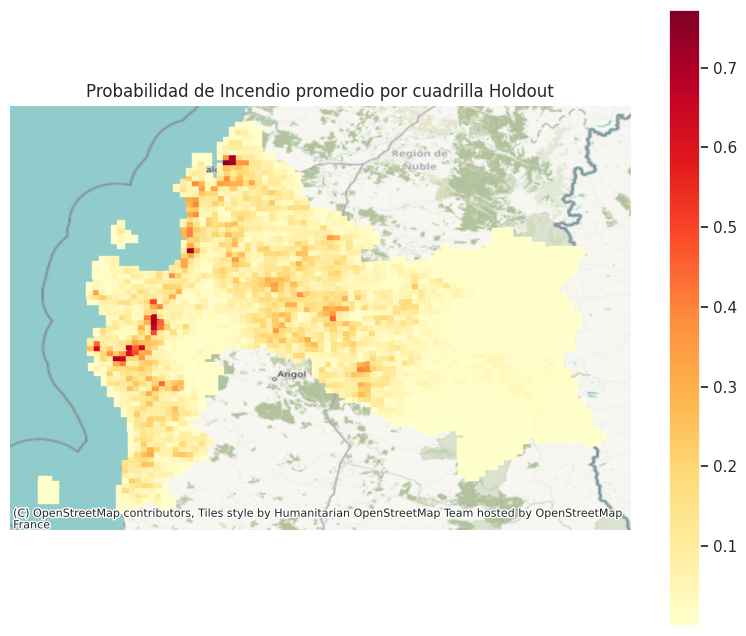

In [132]:
# Crear GeoDataFrame con las coordenadas de latitud y longitud
heatmap_gdf = gp.GeoDataFrame(merged_probs_holdout, geometry=gp.points_from_xy(merged_probs_holdout.longitud, merged_probs_holdout.latitud))

# Crear el gráfico base con la región del Biobío y las cuadrillas
fig, ax = plt.subplots(figsize=(10, 8))
biobio.plot(ax=ax, facecolor="#87CEEB", edgecolor='grey')

# Crear el heatmap de la probabilidad de incendio basado en la latitud y longitud
heatmap_gdf.plot(column='prom_prob_incendio', cmap='YlOrRd', ax=ax, legend=True, markersize=25, marker='s')

# Agregar el fondo del mapa
ctx.add_basemap(ax, crs=biobio.crs)  # Ajusta "biobio.crs" a la proyección de tu datos

# Remover las líneas de los ejes X e Y
ax.axis('off')

# Ajustar título y leyenda
plt.title('Probabilidad de Incendio promedio por cuadrilla Holdout')
plt.xlabel("Longitud (grados)")
plt.ylabel("Latitud (grados)")

plt.show()

Gráfico suavizado

In [ ]:
# @title
# Aplicar un filtro gaussiano a los datos de probabilidad de incendio
prob_incendio_suavizado_holdout = gaussian_filter(merged_probs_holdout['prom_prob_incendio'], sigma=5)

# Agregar la columna con los datos suavizados al DataFrame
merged_probs_holdout['prob_incendio_suavizado'] = prob_incendio_suavizado_holdout

Text(59.5, 0.5, 'Latitud (grados)')

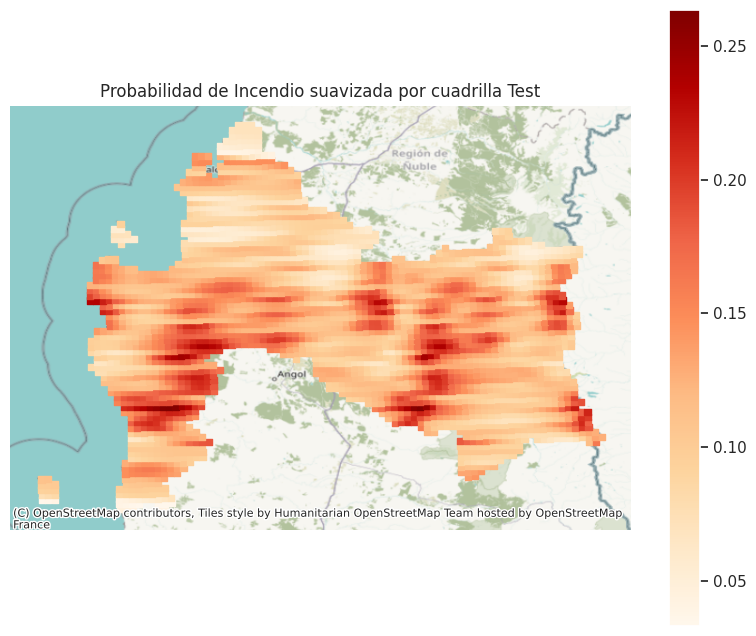

In [ ]:
# @title
# Crear GeoDataFrame con las coordenadas de latitud y longitud
heatmap_gdf = gp.GeoDataFrame(merged_probs_holdout, geometry=gp.points_from_xy(merged_probs_holdout.longitud, merged_probs_holdout.latitud))

# Crear el gráfico base con la región del Biobío y las cuadrillas
fig, ax = plt.subplots(figsize=(10, 8))
biobio.plot(ax=ax, facecolor="#87CEEB", edgecolor='grey')

# Crear el heatmap de la probabilidad de incendio suavizada
heatmap_gdf.plot(column='prob_incendio_suavizado', cmap='OrRd', ax=ax, legend=True, markersize=20, marker='s')

# Agregar el fondo del mapa
ctx.add_basemap(ax, crs=biobio.crs)  # Ajusta "biobio.crs" a la proyección de tu datos

# Remover las líneas de los ejes X e Y
ax.axis('off')

# Ajustar título y leyenda
plt.title('Probabilidad de Incendio suavizada por cuadrilla Test')
plt.xlabel("Longitud (grados)")
plt.ylabel("Latitud (grados)")

##Enero

###Escenario desfavorable

In [92]:
y_pred_proba_rfc_enero_desfav = model_rfc_enero.predict_proba(X_enero_desfav)[:,1]
y_pred_proba_cat_enero_desfav = model_cat_enero.predict_proba(X_enero_desfav)[:,1]

Random Forest

In [93]:
y_pred_df_rfc_enero_desfav = pd.DataFrame(y_pred_proba_rfc_enero_desfav, columns=['prob_incendio'], index=X_enero_desfav.index)
merged_pred_rfc_enero_desfav = pd.concat([enero_desf, y_pred_df_rfc_enero_desfav], axis=1)

prob_incendio_cuadrilla_rfc_enero_desfav = merged_pred_rfc_enero_desfav.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_rfc_enero_desfav.rename(columns={'prob_incendio': 'prom_prob_incendio_rfc'}, inplace=True)

CatBoost

In [94]:
y_pred_df_cat_enero_desfav = pd.DataFrame(y_pred_proba_cat_enero_desfav, columns=['prob_incendio'], index=X_enero_desfav.index)
merged_pred_cat_enero_desfav = pd.concat([enero_desf, y_pred_df_cat_enero_desfav], axis=1)

prob_incendio_cuadrilla_cat_enero_desfav = merged_pred_cat_enero_desfav.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_cat_enero_desfav.rename(columns={'prob_incendio': 'prom_prob_incendio_cat'}, inplace=True)

Mezcla

In [127]:
#Definir umbral (prob catboost si pbb < umbral, prob Random Forest en caso contrario)
umbral = 0.5
merged_probs_enero_desfav = prob_incendio_cuadrilla_cat_enero_desfav.merge(prob_incendio_cuadrilla_rfc_enero_desfav, on=['latitud', 'longitud'], how='inner')
# Crear la nueva columna 'prom_prob_incendio' basada en las condiciones
merged_probs_enero_desfav['prom_prob_incendio'] = np.where(merged_probs_enero_desfav['prom_prob_incendio_cat'] < umbral,
                                              merged_probs_enero_desfav['prom_prob_incendio_cat'],
                                              merged_probs_enero_desfav['prom_prob_incendio_rfc'])

Gráfico

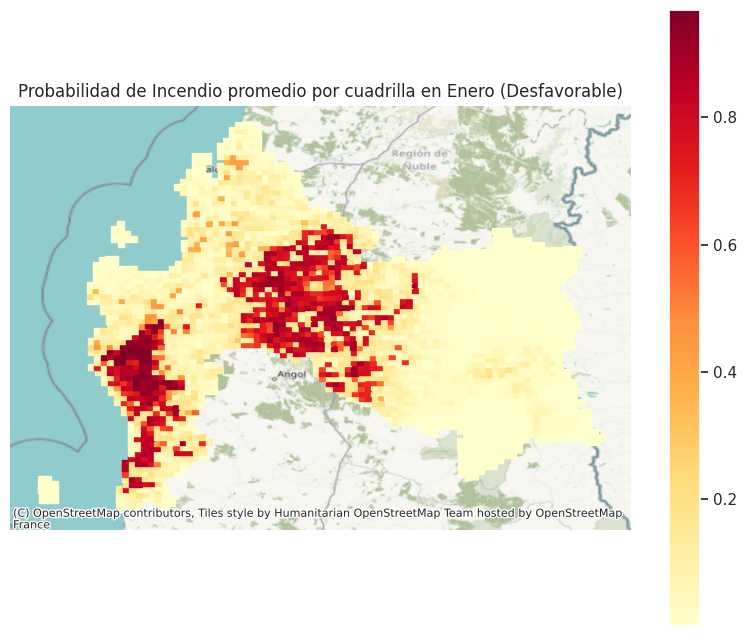

In [128]:
# Crear GeoDataFrame con las coordenadas de latitud y longitud
heatmap_gdf = gp.GeoDataFrame(merged_probs_enero_desfav, geometry=gp.points_from_xy(merged_probs_enero_desfav.longitud, merged_probs_enero_desfav.latitud))

# Crear el gráfico base con la región del Biobío y las cuadrillas
fig, ax = plt.subplots(figsize=(10, 8))
biobio.plot(ax=ax, facecolor="#87CEEB", edgecolor='grey')

# Crear el heatmap de la probabilidad de incendio basado en la latitud y longitud
heatmap_gdf.plot(column='prom_prob_incendio', cmap='YlOrRd', ax=ax, legend=True, markersize=20, marker='s')

# Agregar el fondo del mapa
ctx.add_basemap(ax, crs=biobio.crs)  # Ajusta "biobio.crs" a la proyección de tu datos

# Remover las líneas de los ejes X e Y
ax.axis('off')

# Ajustar título y leyenda
plt.title('Probabilidad de Incendio promedio por cuadrilla en Enero (Desfavorable)')
plt.xlabel("Longitud (grados)")
plt.ylabel("Latitud (grados)")

plt.show()

###Escenario promedio

In [99]:
#Probabilidades de predicción de los modelos
y_pred_proba_rfc_enero_prom = model_rfc_enero.predict_proba(X_enero_prom)[:,1]
y_pred_proba_cat_enero_prom = model_cat_enero.predict_proba(X_enero_prom)[:,1]

Random Forest

In [100]:
y_pred_df_rfc_enero_prom = pd.DataFrame(y_pred_proba_rfc_enero_prom, columns=['prob_incendio'], index=X_enero_prom.index)
merged_pred_rfc_enero_prom = pd.concat([enero_prom, y_pred_df_rfc_enero_prom], axis=1)

prob_incendio_cuadrilla_rfc_enero_prom = merged_pred_rfc_enero_prom.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_rfc_enero_prom.rename(columns={'prob_incendio': 'prom_prob_incendio_rfc'}, inplace=True)

CatBoost

In [101]:
y_pred_df_cat_enero_prom = pd.DataFrame(y_pred_proba_cat_enero_prom, columns=['prob_incendio'], index=X_enero_prom.index)
merged_pred_cat_enero_prom = pd.concat([enero_prom, y_pred_df_cat_enero_prom], axis=1)

prob_incendio_cuadrilla_cat_enero_prom = merged_pred_cat_enero_prom.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_cat_enero_prom.rename(columns={'prob_incendio': 'prom_prob_incendio_cat'}, inplace=True)

Mezcla

In [133]:
#Definir umbral (prob catboost si pbb < umbral, prob Random Forest en caso contrario)
umbral = 0.5
merged_probs_enero_prom = prob_incendio_cuadrilla_cat_enero_prom.merge(prob_incendio_cuadrilla_rfc_enero_prom, on=['latitud', 'longitud'], how='inner')
# Crear la nueva columna 'prom_prob_incendio' basada en las condiciones
merged_probs_enero_prom['prom_prob_incendio'] = np.where(merged_probs_enero_prom['prom_prob_incendio_cat'] < umbral,
                                              merged_probs_enero_prom['prom_prob_incendio_cat'],
                                              merged_probs_enero_prom['prom_prob_incendio_rfc'])

Gráfico

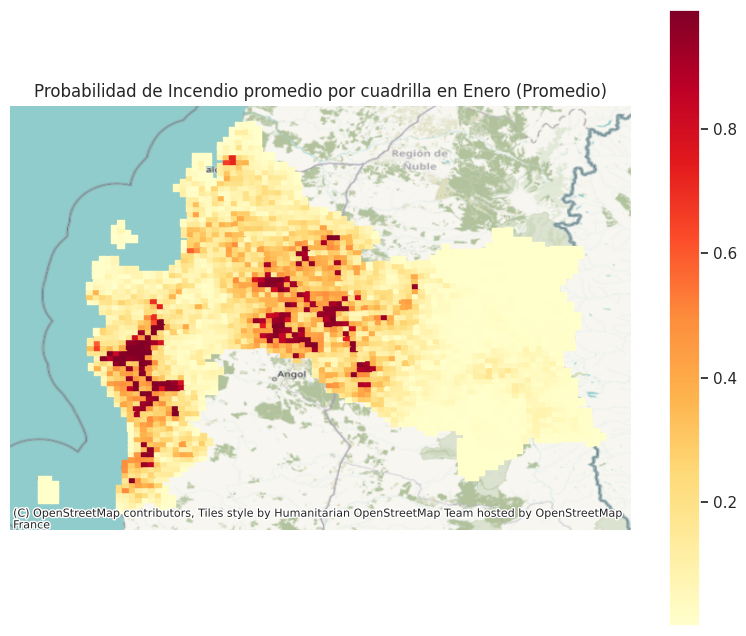

In [134]:
# Crear GeoDataFrame con las coordenadas de latitud y longitud
heatmap_gdf = gp.GeoDataFrame(merged_probs_enero_prom, geometry=gp.points_from_xy(merged_probs_enero_prom.longitud, merged_probs_enero_prom.latitud))

# Crear el gráfico base con la región del Biobío y las cuadrillas
fig, ax = plt.subplots(figsize=(10, 8))
biobio.plot(ax=ax, facecolor="#87CEEB", edgecolor='grey')

# Crear el heatmap de la probabilidad de incendio basado en la latitud y longitud
heatmap_gdf.plot(column='prom_prob_incendio', cmap='YlOrRd', ax=ax, legend=True, markersize=25, marker='s')

# Agregar el fondo del mapa
ctx.add_basemap(ax, crs=biobio.crs)  # Ajusta "biobio.crs" a la proyección de tu datos

# Remover las líneas de los ejes X e Y
ax.axis('off')

# Ajustar título y leyenda
plt.title('Probabilidad de Incendio promedio por cuadrilla en Enero (Promedio)')
plt.xlabel("Longitud (grados)")
plt.ylabel("Latitud (grados)")

plt.show()

###Escenario favorable

In [104]:
y_pred_proba_rfc_enero_fav = model_rfc.predict_proba(X_enero_fav)[:,1]
y_pred_proba_cat_enero_fav = model_cat.predict_proba(X_enero_fav)[:,1]

Random Forest

In [105]:
y_pred_df_rfc_enero_fav = pd.DataFrame(y_pred_proba_rfc_enero_fav, columns=['prob_incendio'], index=X_enero_fav.index)
merged_pred_rfc_enero_fav = pd.concat([enero_fav, y_pred_df_rfc_enero_fav], axis=1)

prob_incendio_cuadrilla_rfc_enero_fav = merged_pred_rfc_enero_fav.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_rfc_enero_fav.rename(columns={'prob_incendio': 'prom_prob_incendio_rfc'}, inplace=True)

CatBoost

In [106]:
y_pred_df_cat_enero_fav = pd.DataFrame(y_pred_proba_cat_enero_fav, columns=['prob_incendio'], index=X_enero_fav.index)
merged_pred_cat_enero_fav = pd.concat([enero_fav, y_pred_df_cat_enero_fav], axis=1)

prob_incendio_cuadrilla_cat_enero_fav = merged_pred_cat_enero_fav.groupby(['latitud', 'longitud'])['prob_incendio'].mean().reset_index()
prob_incendio_cuadrilla_cat_enero_fav.rename(columns={'prob_incendio': 'prom_prob_incendio_cat'}, inplace=True)


Mezcla

In [135]:
#Definir umbral (prob catboost si pbb < umbral, prob Random Forest en caso contrario)
umbral = 0.5
merged_probs_enero_fav = prob_incendio_cuadrilla_cat_enero_fav.merge(prob_incendio_cuadrilla_rfc_enero_fav, on=['latitud', 'longitud'], how='inner')
# Crear la nueva columna 'prom_prob_incendio' basada en las condiciones
merged_probs_enero_fav['prom_prob_incendio'] = np.where(merged_probs_enero_fav['prom_prob_incendio_cat'] < umbral,
                                              merged_probs_enero_fav['prom_prob_incendio_cat'],
                                              merged_probs_enero_fav['prom_prob_incendio_rfc'])

Gráfico

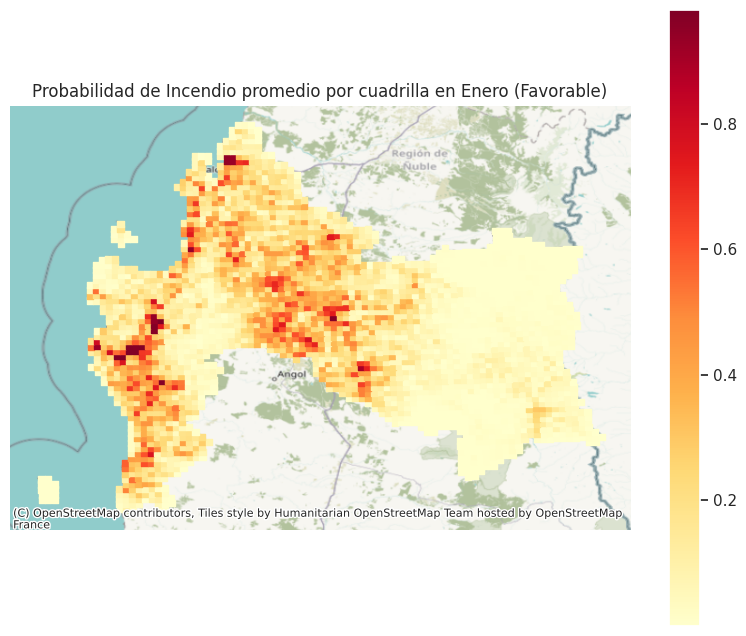

In [136]:
# Crear GeoDataFrame con las coordenadas de latitud y longitud
heatmap_gdf = gp.GeoDataFrame(merged_probs_enero_fav, geometry=gp.points_from_xy(merged_probs_enero_fav.longitud, merged_probs_enero_fav.latitud))

# Crear el gráfico base con la región del Biobío y las cuadrillas
fig, ax = plt.subplots(figsize=(10, 8))
biobio.plot(ax=ax, facecolor="#87CEEB", edgecolor='grey')

# Crear el heatmap de la probabilidad de incendio basado en la latitud y longitud
heatmap_gdf.plot(column='prom_prob_incendio', cmap='YlOrRd', ax=ax, legend=True, markersize=20, marker='s')

# Agregar el fondo del mapa
ctx.add_basemap(ax, crs=biobio.crs)  # Ajusta "biobio.crs" a la proyección de tu datos

# Remover las líneas de los ejes X e Y
ax.axis('off')

# Ajustar título y leyenda
plt.title('Probabilidad de Incendio promedio por cuadrilla en Enero (Favorable)')
plt.xlabel("Longitud (grados)")
plt.ylabel("Latitud (grados)")

plt.show()

In [110]:
promedio_prob_incendio_fav = merged_probs_enero_fav['prom_prob_incendio'].mean()
print("probabilidad de incendio promedio total, escenario favorable:", promedio_prob_incendio_fav)

promedio_prob_incendio_prom = merged_probs_enero_prom['prom_prob_incendio'].mean()
print("probabilidad de incendio promedio total, escenario promedio:", promedio_prob_incendio_prom)

promedio_prob_incendio_desfav = merged_probs_enero_desfav['prom_prob_incendio'].mean()
print("probabilidad de incendio promedio total, escenario desfavorable:", promedio_prob_incendio_desfav)


probabilidad de incendio promedio total, escenario favorable: 0.17353786482646305
probabilidad de incendio promedio total, escenario promedio: 0.17181987379767064
probabilidad de incendio promedio total, escenario desfavorable: 0.12216255047689818


##Para Power BI

Usando el escenario promedio

In [117]:
# Crear una copia del DataFrame original
rfc = merged_pred_rfc_enero_prom.copy()

# Renombrar la columna 'prob_incendio' a 'prob_incendio_rfc' en la copia del DataFrame
rfc.rename(columns={'prob_incendio': 'prob_incendio_rfc'}, inplace=True)
rfc.head()

,cuadrilla,dia,geometry,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,...,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,longitud,latitud,prob_incendio_rfc
0,0,1,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.420000,0.150000,-73.942629,-38.432372,0.0
1,0,2,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.120000,0.900000,-73.942629,-38.432372,0.0
2,0,3,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.916667,1.216667,-73.942629,-38.432372,0.0
3,0,4,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.850000,2.050000,-73.942629,-38.432372,0.0
4,0,5,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.350000,2.616667,-73.942629,-38.432372,0.0


In [118]:
cat = merged_pred_cat_enero_prom.copy()

# Renombrar la columna 'prob_incendio' a 'prob_incendio_cat' en la copia del DataFrame
cat.rename(columns={'prob_incendio': 'prob_incendio_cat'}, inplace=True)

In [119]:
#Definir umbral (prob catboost si pbb < umbral, prob Random Forest en caso contrario)
umbral = 0.5
predicciones = cat.merge(rfc, how='inner')
# Crear la nueva columna 'prom_prob_incendio' basada en las condiciones
predicciones['prob_incendio'] = np.where(predicciones['prob_incendio_cat'] < umbral,
                                              predicciones['prob_incendio_cat'],
                                              predicciones['prob_incendio_rfc'])

In [120]:
# Crear la columna 'semana'
predicciones['semana'] = ((predicciones['dia'] - 1) // 7) + 1

# Calcular la columna 'mes'
def obtener_mes(dia):
    dias_por_mes = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    mes = 1
    dias_acumulados = 0
    for num_dias in dias_por_mes:
        dias_acumulados += num_dias
        if dia <= dias_acumulados:
            return mes
        mes += 1

predicciones['mes'] = predicciones['dia'].apply(obtener_mes)


In [ ]:
#Calcular la columna 'dia_del_mes'
'''def obtener_dia_del_mes(row):
    dias_por_mes = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dias_acumulados = 0
    for index, value in enumerate(dias_por_mes[:int(row['mes']) - 1]):
        dias_acumulados += value
    return row['dia'] - dias_acumulados

predicciones['dia_del_mes'] = predicciones.apply(obtener_dia_del_mes, axis=1)

In [121]:
predicciones

,cuadrilla,dia,geometry,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,...,altura,t_prom,prep_prom,longitud,latitud,prob_incendio_cat,prob_incendio_rfc,prob_incendio,semana,mes
0,0,1,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0.0,19.420000,0.150000,-73.942629,-38.432372,0.000038,0.0,0.000038,1,1
1,0,2,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0.0,19.120000,0.900000,-73.942629,-38.432372,0.000153,0.0,0.000153,1,1
2,0,3,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0.0,18.916667,1.216667,-73.942629,-38.432372,0.000138,0.0,0.000138,1,1
3,0,4,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0.0,19.850000,2.050000,-73.942629,-38.432372,0.000155,0.0,0.000155,1,1
4,0,5,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0.0,19.350000,2.616667,-73.942629,-38.432372,0.000099,0.0,0.000099,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91724,2958,27,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,2235.0,20.961833,0.166667,-70.971548,-38.097640,0.000384,0.0,0.000384,4,1
91725,2958,28,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,2235.0,21.201667,0.000000,-70.971548,-38.097640,0.000243,0.0,0.000243,4,1
91726,2958,29,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,2235.0,21.617000,0.000000,-70.971548,-38.097640,0.000339,0.0,0.000339,5,1
91727,2958,30,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,2235.0,22.033000,0.000000,-70.971548,-38.097640,0.000432,0.0,0.000432,5,1


In [122]:
predicciones.to_csv('predicciones.csv', index=False)